<a href="https://colab.research.google.com/github/hughesymendes/TIC-27491137/blob/combining_dips/NewModelAH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightkurve

!pip install exoplanet

!pip install pymc3==3.8

!pip install corner

     |████████████████████████████████| 2.1MB 4.8MB/s 
     |████████████████████████████████| 25.9MB 161kB/s 
     |████████████████████████████████| 256kB 31.8MB/s 
     |████████████████████████████████| 6.5MB 22.4MB/s 
     |████████████████████████████████| 2.7MB 38.1MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-cp36-none-any.whl size=11376 sha256=3fe5e746dbe53c97aee298b1d65d4eb2eeafcf8e134a087efb059dc81c2e0f6a
  Stored in directory: /root/.cache/pip/wheels/53/a2/dd/9b66cf53dbc58cec1e613d216689e5fa946d3e7805c30f60dc
  Created wheel for astroquery: filename=astroquery-0.4.1-cp36-none-any.whl size=3831873 sha256=3b93038870bf3a3d3411b6ab8cf386500d4ad9d67d8d6ee7d0b10961ed20037c
  Stored in directory: /root/.cache/pip/wheels/88/f8/b7/a254cd96e808f708bc0b7d755a8e095c56fbbe94099d7b464f
  Created wheel for oktopus: filename=oktopus-0.1.2-cp36-none-any.whl size=12779 sha256=a2f47b02f6b295ead4889fa2463d450631ff537d10820b1d1d4007279f91f75f
  Stored in directory: /root/.cache/pip/wheels

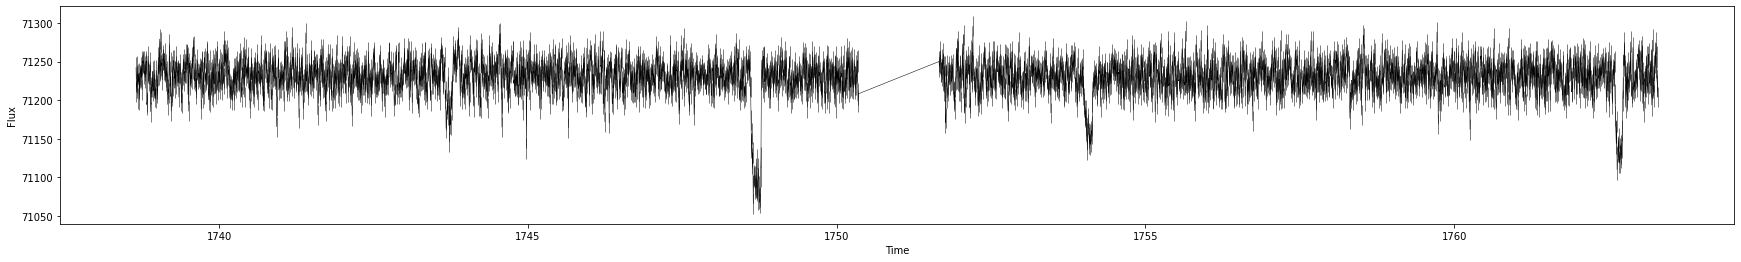

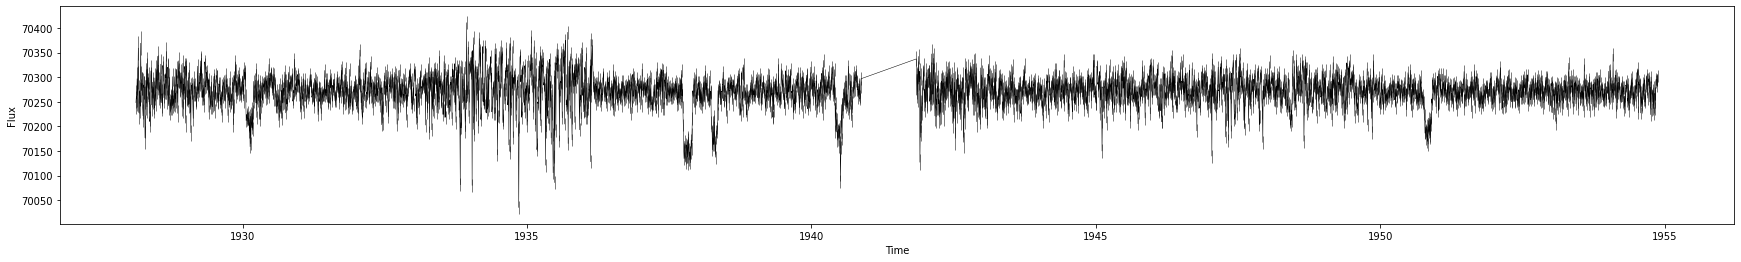

In [2]:
import lightkurve as lk
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel
%matplotlib inline

flags = lk.utils.TessQualityFlags
q = flags.CoarsePoint | flags.Desat | flags.Argabrightening

tpfs = lk.search_targetpixelfile("TIC 27491137").download_all(quality_bitmask=q)

clcs = []
for tpf in tpfs:
    breaks = np.where(np.append(False, np.diff(tpf.time) > (np.median(np.diff(tpf.time)) * 5)))[0]
    aper = tpf.create_threshold_mask()


    lc = tpf.to_lightcurve()

    # Scattered light
    bkg = tpf.get_bkg_lightcurve(tpf.pipeline_mask)
    bkg[~np.isfinite(lc.flux_err)].flux *= 0
    lc += bkg
    lc.flux_err[~np.isfinite(lc.flux_err)] = np.nanmedian(lc.flux_err)

    bkg = tpf.flux_bkg
    bkg[~np.isfinite(bkg)] = 0
    pixels = (tpf.flux + bkg)[:, ~aper]
    dm1 = lk.DesignMatrix(pixels, name='pixels').pca(3).split(list(breaks)).append_constant()

    # Pos corr
    ts = np.vstack([((tpf.time - t[0])/(t[-1] - t[0]) - 0.5) * np.in1d(tpf.time, t) for t in np.array_split(tpf.time, [np.where(np.diff(tpf.time) > 0.5)[0][0] + 1])]).T
    p1 = np.vstack([np.nan_to_num(tpf.pos_corr1) * np.in1d(tpf.time, t)  for t in np.array_split(tpf.time, [np.where(np.diff(tpf.time) > 0.5)[0][0] + 1])]).T
    p2 = np.vstack([np.nan_to_num(tpf.pos_corr2) * np.in1d(tpf.time, t)  for t in np.array_split(tpf.time, [np.where(np.diff(tpf.time) > 0.5)[0][0] + 1])]).T
    pdm = lk.DesignMatrix(np.hstack([ts, ts**2, p1, p2, p1*p2, p1**2*p2, p1*p2**2, p1**2*p2**2]), name = 'poscorrs')
    pdm.prior_sigma = np.ones(pdm.shape[1]) * 0.01


    spline = lk.designmatrix.create_spline_matrix(lc.time, n_knots=80)

    dm = lk.DesignMatrixCollection([dm1, pdm, spline])

    # First iteration
    r = lk.RegressionCorrector(lc)
    clean_lc = r.correct(dm, sigma=1e10)

    # YOU SHOULD REPLACE THIS HACKY MASK WITH A BETTER ONE.
    a = (clean_lc).bin(10).flatten(81)
    _, m = a.remove_outliers(2, return_mask=True)
    m = (convolve(m, Box1DKernel(10)) > 0.5)
    mask = np.interp(clean_lc.time, a.time, m) > 0
    mask = convolve(mask, Box1DKernel(5)) > 0

    # second iteration
    r = lk.RegressionCorrector(lc)
    clean_lc = r.correct(dm, sigma=1e10, cadence_mask=~mask)

    clean_lc = lk.LightCurve(np.asarray(clean_lc.time, np.float64),
                         np.asarray(clean_lc.flux, np.float64),
                         np.asarray(clean_lc.flux_err, np.float64))

    fig, ax = plt.subplots(figsize=(30, 4))
    (clean_lc).bin(5, method='median').errorbar(ls='-', ax=ax, c='k')
    
    clcs.append(clean_lc.normalize())

In [3]:
clc = lk.LightCurveCollection(clcs).stitch()

/usr/local/lib/python3.6/dist-packages/lightkurve/lightcurve.py:702: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  LightkurveWarning)


In [ ]:
clc[32000:32950].plot()

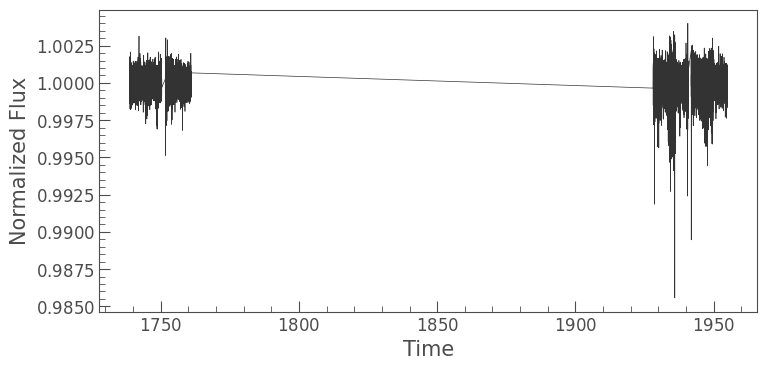

In [4]:
mask1 = (clc.time < 1761) | (clc.time > 1764) 
m1lc = clc[mask1]
mask2 = (m1lc.time < 1938.1)| (m1lc.time > 1938.44) 
lc =  m1lc[mask2]
lc.plot()

In [5]:
lc.flux.shape

(33453,)

In [6]:
import theano.tensor as tt
masks = [tt.as_tensor(np.in1d(np.arange(len(lc.flux)), np.arange(a, b)).astype(float)) for a, b in zip([3000, 6800, 9500, 17500, 23500, 32000], [4200, 7688, 10800, 19000, 24000, 32950])]

In [7]:
dips = [(lc/mask.eval())[np.isfinite(1/mask.eval())] for mask in masks]

In [10]:
import pymc3 as pm
import exoplanet as xo
from exoplanet.gp import terms, GP
with pm.Model() as model:
    mean = pm.Normal("mean", mu=1, sd=0.01)

    log_sigma = pm.Uniform("log_sigma", lower=-10, upper=10)
    log_rho = pm.Uniform("log_rho", lower=-10, upper=10)

    # Set up the kernel an GP
  #  kernel = terms.Matern32Term(log_sigma=log_sigma, log_rho=log_rho)
  #  gp = GP(kernel, lc.time, lc.flux_err ** 2)
  #  gp = GP(kernel, clean_lc.time, clean_lc.flux_err ** 2)


    # Stellar variables
    r_star = pm.Normal("r_star", mu=0.772148, sd=0.0454673, testval=0.78)    
    m_star = pm.Normal("m_star", mu=0.87, sd=0.108032, testval=0.87)
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.525, 0.215]))


    #Super Earth candidate 1
    tv = 1743.72
    t01 = pm.Uniform("t01", lower=tv-0.1, upper=tv+0.1)
    period1 = pm.Uniform("period1", lower=8, upper=12, testval=10)
    r1 = pm.Uniform("r1", lower=0.001, upper=0.1, testval=0.04)
    b1 = xo.distributions.ImpactParameter("b1", ror=r1/r_star)
    orbit1 = xo.orbits.KeplerianOrbit(period=period1, t0=t01, b=b1, r_star=r_star, m_star=m_star) 
    light_curve1 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit1, r=r1, t=clean_lc.time)[:, 0]

    #Uranus sized candidate
    tv = 1748.69 
    t02 = pm.Uniform("t02", lower=tv-0.1, upper=tv+0.1)
    period2 = pm.Uniform("period2", lower=0, upper=200, testval=30)
    r2 = pm.Uniform("r2", lower=0.001, upper=0.1, testval=0.04)
    b2 = xo.distributions.ImpactParameter("b2", ror=r2/r_star)
    orbit2 = xo.orbits.KeplerianOrbit(period=period2, t0=t02, b=b2, r_star=r_star, m_star=m_star) 
    light_curve2 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit2, r=r2, t=clean_lc.time)[:, 0] * masks[0]



    #Spare transit setup, not required for the first runthrough but will be needed for the second super earth so kept for easy copy pasta

    #tv =  1762.67
    #t03 = pm.Uniform("t03", lower=tv-0.1, upper=tv+0.1)
    #period3 = pm.Uniform("period3", lower=0, upper=200, testval=30)
    #r3 = pm.Uniform("r3", lower=0.001, upper=0.1, testval=0.04)
    #b3 = xo.distributions.ImpactParameter("b3", ror=r3/r_star)
    #orbit3 = xo.orbits.KeplerianOrbit(period=period3, t0=t03, b=b2, r_star=r_star, m_star=m_star) 
    #light_curve3 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit3, r=r3, t=clean_lc.time)[:, 0] * masks[2]



    light_curve = pm.Deterministic('light_curve', light_curve1 + light_curve2 + mean)
    
    
    # This was already commented out.

#s    pm.Normal("obs1", mu=light_curve, sd=clean_lc.flux_err, observed=clean_lc.flux)
    
#     # Fit for the maximum a posteriori parameters given the simuated dataset
#     # Posterior distribution is usually given as Prior*Likelihood


     #Condition the GP on the observations and add the marginal likelihood
     #to the model
   # gp.marginal("gp", observed=lc.flux - light_curve)

   # gp_pred = pm.Deterministic('gp_pred', gp.predict())



    #The following few lines was taken from the old model to include the actual dataset as we are not using the GP
    y = lc.time

    # The likelihood function assuming known Gaussian uncertainty- 
    #Likelihood function is a function that represents the distribution from an actual test sample
    pm.Normal("obs", mu=light_curve, sd=lc.flux_err, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated dataset
    # Posterior distribution is usually given as Prior*Likelihood



  #Optimising variables in stages to see if there is any area with a large precision loss.
  #This is good practise as it helps with debugging and also means we dont sample from a trash model
    
    map_soln = xo.optimize(start=model.test_point, vars=[log_sigma, log_rho])
    map_soln = xo.optimize(start=map_soln, vars=[t01, t02, mean])
    map_soln = xo.optimize(start=map_soln, vars=[r1, r2])
    map_soln = xo.optimize(start=map_soln, vars=[period1])
    map_soln = xo.optimize(start=map_soln, vars=[period2])
    map_soln = xo.optimize(start=map_soln, vars=[t01, t02 , mean, r1, r2, period1, period2, b1, b2, log_sigma, log_rho])

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


ValueError: ignored

In [ ]:
clc.plot()
plt.plot(clean_lc.time, map_soln['gp_pred'] + map_soln['mean'])
plt.plot(clean_lc.time, map_soln['light_curve'])

In [ ]:
for d in dips:
    plt.figure()
    (clean_lc - (map_soln['gp_pred'])).errorbar()
    plt.xlim(d.time[0], d.time[-1])

In [13]:
with model:
    trace = pm.sample(
        tune=1000,
        draws=500,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Sequential sampling (4 chains in 1 job)
NUTS: [b2, r2, period2, t02, b1, r1, period1, t01, u, m_star, r_star, log_rho, log_sigma, mean]
Sampling chain 0, 0 divergences:   0%|          | 0/1500 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling chain 3, 0 divergences: 100%|██████████| 1500/1500 [00:05<00:00, 251.75it/s]
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an err

In [14]:
labels = ['t01', 't02', 'mean',
          'period1', 'period2',
          'r1', 'r2', 'b1', 'b2', 'u']

In [15]:
pm.summary(trace, varnames=labels)

/usr/local/lib/python3.6/dist-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
t01,1743.719,0.057,1743.631,1743.816,0.001,0.001,3947.0,3947.0,3823.0,1507.0,1.00
t02,1748.691,0.057,1748.601,1748.787,0.001,0.001,3830.0,3830.0,3626.0,1334.0,1.00
mean,1.000,0.010,0.985,1.021,0.000,0.000,3110.0,3105.0,3121.0,1685.0,1.00
period1,10.022,1.166,8.240,11.994,0.018,0.013,4047.0,3995.0,3721.0,1504.0,1.01
period2,100.510,57.659,5.942,192.761,1.022,0.790,3183.0,2662.0,2765.0,1269.0,1.00
r1,0.050,0.029,0.005,0.098,0.000,0.000,3546.0,2975.0,3339.0,1240.0,1.00
r2,0.050,0.029,0.002,0.095,0.000,0.000,4293.0,3303.0,4181.0,1460.0,1.00
b1,0.537,0.298,0.016,1.006,0.005,0.004,2979.0,2652.0,2790.0,1303.0,1.00
b2,0.539,0.311,0.004,1.008,0.006,0.004,3110.0,2680.0,2774.0,1349.0,1.00
u[0],0.672,0.468,0.000,1.504,0.009,0.007,2700.0,2339.0,2478.0,875.0,1.00


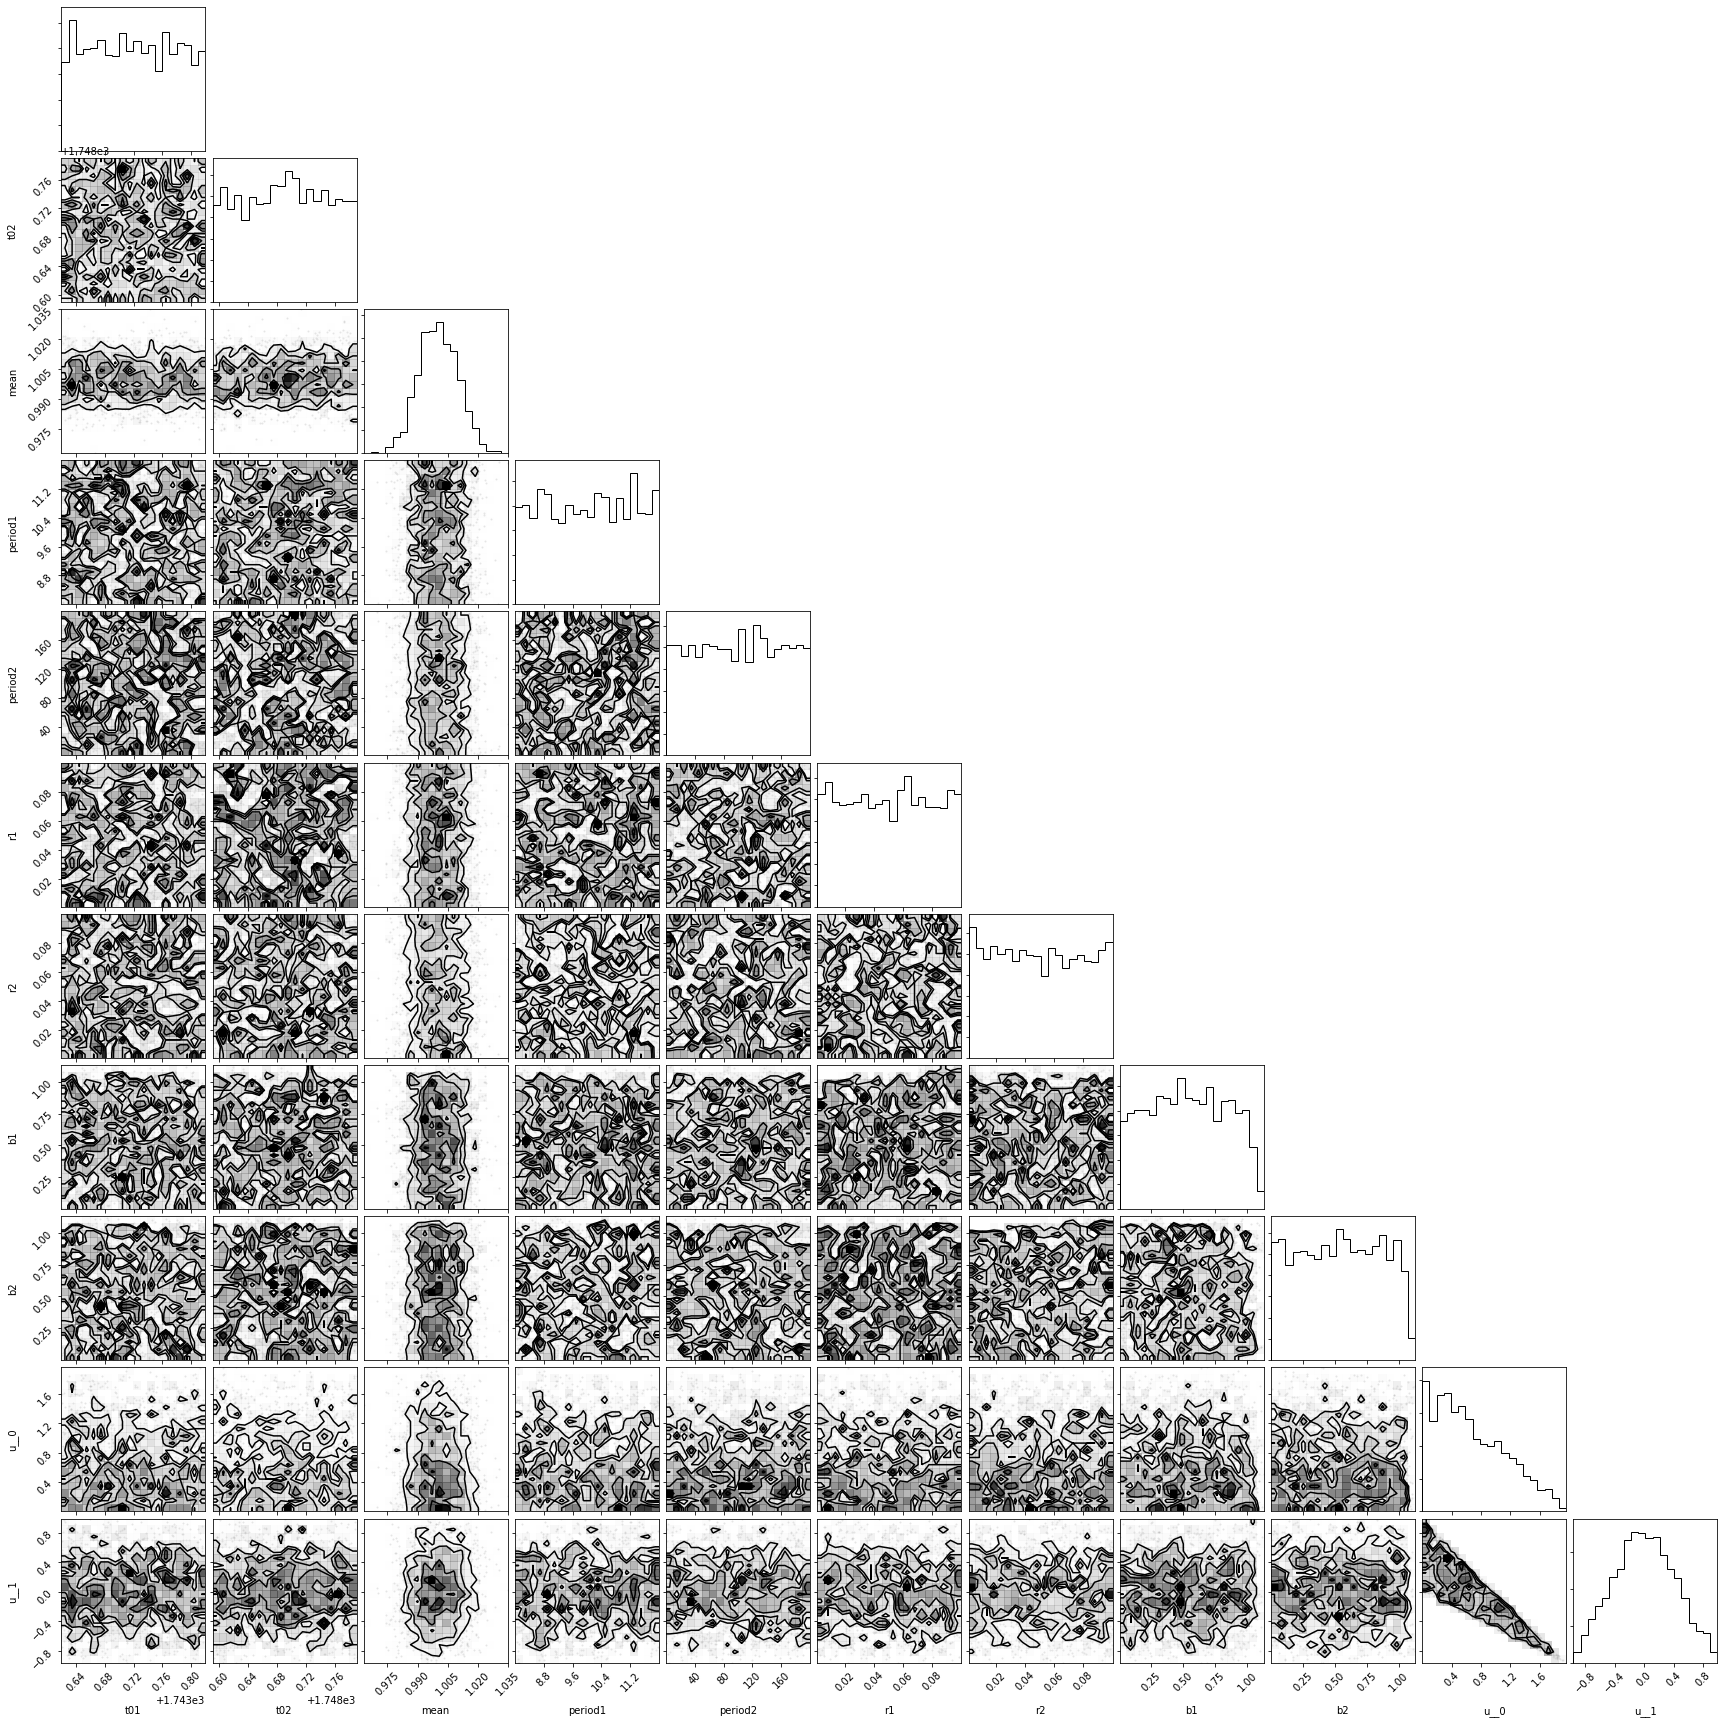

In [16]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=labels)
fig = corner.corner(samples)
fig.savefig('corner.png', dpi=200, bbox_inches='tight')


In [ ]:
mu, lower, upper = np.percentile(trace['gp_pred'] + trace['light_curve'], [50, 16, 84], axis=0)

In [ ]:
ax = clean_lc.errorbar()
ax.fill_between(clean_lc.time, lower, upper, zorder=10, color='r', alpha=0.7)


In [ ]:
for d in dips:
    ax = clean_lc.errorbar(zorder=-1)
    ax.fill_between(clean_lc.time, lower, upper, zorder=10, color='r', alpha=0.7)
#    ax.plot(clean_lc.time, mu, zorder=10, color='r')

    ax.set_xlim(d.time[0], d.time[-1])

In [ ]:
(((trace['t03'] - trace['t02']) + (trace['t04'] - trace['t03']))/2)

In [ ]:
import pandas as pd
pd.DataFrame([np.append([label], np.nanpercentile(trace[label], [50, 16, 84])) for label in labels], columns=['Name', 'Mean', "Lower Percentile", "Upper Percentile"])

In [ ]:
# SAVE THE MAP SOLUTION
import pickle
pickle.dump(map_soln, open('map_soln.p', 'wb'))

# Make sure it's committed to github somewhere

In [ ]:
results = {var:np.percentile(trace[var], [50, 16, 84], axis=-1) for var in trace.varnames}

In [ ]:
results

In [ ]:
pickle.dump(results, open('results.p', 'wb'))

In [ ]:
from google.colab import files

#results
filename = "Results.pickle"
outfile = open(filename, "wb")
pickle.dump(results, outfile)
outfile.close()
files.download('Results.pickle')
